Refer to https://d2l.ai to an (almost) complete review about Deep Learning.

We use the [TensorFlow](https://www.tensorflow.org/) framework. In particular, the [Keras](https://keras.io/) dialect (sub-package of TensorFlow).

# Brief recap of Dense NN

A Dense Neural Network model is defined as a sequence of *dense layers*. 

Each dense layer is a fully-connected layer which consists in a vector $I \in R^{1xn}$ of $n$ inputs (i.e. *input neurons*) and a vector $O \in R^{1xm}$ of $m$ outputs (i.e. *output neurons*).

Each output neuron takes input from all input neurons, with a weigth corresponding to each input neuron: vector $W \in R^{1xn}$ of $n$ weigths. In addition, each output neuron has also a bias $b$ (scalar). The value of the output neuron is computed as $o = I*W+b$, where $I*W$ is the dot product.

We have $m$ output neurons, with independent weigths. So, on the whole, we have a matrix $W \in R^{nxm}$ of weigths. In addition, each output neuron has its own bias: vector $B$ of $m$ biases. Therefore, on the whole the dense layer computes the following operation: $O = I*W+B$, where $I*B$ is the rows-by-columns product.

The matrix $W$ plus the vector $B$ are the parameters of the layer. They are the parameters that must be learnt. 

Finally, in addition to all that, an activation function $\sigma$ can be applied: $O = \sigma(I*W+B)$.

Without the activation function, a dense layer simply computes a linear operation. The aim of the activation function is mainly to add non-linearity into out layer, in order to make it more powerful and expressive.

# FirstDenseNN MNISTdataset

A first example of a simple Dense Neural Network, applied to a well known dataset: the MNIST dataset.

The classic MNIST dataset is a dataset about images representing handwritten digits. 

Basically, there are $N$ images. Each image represents a certain digit. Each digit represents a certain number among $0, 1, ..., 9$.

Each image is labeled with the digit represented by that image. This is the class of the image. $10$ different classes: $0, 1, ..., 9$.

## IMPORTING LIBRARIES

As always, the first thing we need to do is importing libraries.

In [1]:
# Utilities
import numpy as np
import matplotlib.pyplot as plt

# Deep Learning
import tensorflow as tf
from tensorflow import keras

# Import keras dataset Mnist
from tensorflow.keras.datasets import mnist

## LOAD THE DATASET

Let us load the mnist dataset. It is already splitted into train-test.

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

Let's check the dimensions of the dataset.

In [3]:
print('There are {} samples in the training set'.format(x_train.shape[0]))
print('There are {} samples in the test set'.format(x_test.shape[0]))

There are 60000 samples in the training set
There are 10000 samples in the test set


### Input data `x`

Let's better inspect the input data `x`. 

Each instance is an greyscale image, with $28*28$ pixels. 

For example, let's see the shape of the first instance.

In [4]:
x_train[0].shape

(28, 28)

Each pixel has a value in the range $[0,255]$.

In [5]:
print('Range of the values in x_train: [{},{}]'.format(x_train.min(),x_train.max()))
print('Range of the values in x_test: [{},{}]'.format(x_test.min(),x_test.max()))

Range of the values in x_train: [0,255]
Range of the values in x_test: [0,255]


Let's see the image representation of the first instance of the training set.

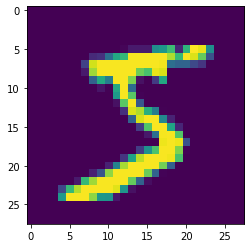

In [6]:
plt.imshow(x_train[0])

So, each instance in `x` is a matrix. This means that the input data `x` (both the `x_train` and the `x_test`) is a tensor (i.e. it has 3 dimensions).

In [7]:
print('x_train dimensions:', x_train.shape)
print('x_test dimensions:', x_test.shape)

x_train dimensions: (60000, 28, 28)
x_test dimensions: (10000, 28, 28)


### Target vector `y`

The target vector `y` contains the label/class of each image. In other words, it contains the digit represented by each image.

In total, there are $10$ different classes, represented as numbers: $0, 1, ..., 9$. They are the $10$ different digits.

In [8]:
np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

Let's see the label of the first image in the training set.

In [9]:
y_train[0]

5

## PRE-PROCESSING

Some pre-processing operations must be performed.

### 1) Normalization of the input data `x`

The values in `x` (both `x_train` and `x_test`) are in the range $[0,255]$. We want to normalize these values into the range $[0,1]$. Remapping the values into the range $[0,1]$.

Why do we do that? Because the computations becomes faster, easier, and it improves the results. 

For doing this transformation, we simply use the **MinMaxScaling technique**. Basically, we take each value `x_{ij}` of `x`, we subtract the min of `x` and we divide by the difference between the max value of `x` and the min value of `x`. In this way we get the new value $x'_{ij}$.

$x'_{ij} = \frac{x_{ij} - x_{min}}{x_{max}-x_{min}}$

Doing this transformation, all the values in `x` are now in the range $[0,1]$.

We apply this transformation both in the training set `x_train` and in the test set `x_test`.

In [10]:
x_train = (x_train - x_train.min()) / ( x_train.max() - x_train.min())

x_test = (x_test - x_test.min()) / ( x_test.max() - x_test.min())

In [11]:
print('Range of the values in x_train: [{},{}]'.format(x_train.min(),x_train.max()))
print('Range of the values in x_test: [{},{}]'.format(x_test.min(),x_test.max()))

Range of the values in x_train: [0.0,1.0]
Range of the values in x_test: [0.0,1.0]


**N.B.**

Since the min value of both `x_train` and `x_test` is $0$ (and the maximum is $255$), the MinMaxScaling operation could have been simply achieved in the following way.

In [12]:
x_train = x_train / 255.0
x_test = x_test / 255.0

### 2) Flattening of the input data `x`

The instances in the input data `x` are bidimensional structures: they are images. They are $28*28$ matrices.

Since we are using dense layers, we need to flat the images into one-dimensional vectors with $28*28=784$ elements. (Dense layers work with a flat input).

We can do that in two ways.
1. We modify the input data `x` (both training and test) in such a way that each instance now is the flat representation of an image. Each instance now is a vector with $28*28=784$ values. So, we modify our input data `x`.
2. We don't modify our input data `x`, but we keep it as it is: the instances are images. However, we add in the beginning of the NN a special layer whose purpose is to flat the image received in input (FlatLayer). Layer which takes a $28*28$ image and flats it into a vector with length $784$.

In this notebook we use the first way. In the next notebooks we will use the second way. *The second is in general better, because we don't need to pre-process our input data `x`: our input data `x` is kept as it is*.

For reshaping the input data `x` we use the NumPy `reshape` method.

In [13]:
# Flattening each image in the training set
x_train = np.reshape(x_train, (60000,28*28)) 

# Flattening each image in the test set
x_test = np.reshape(x_test, (10000,28*28))

### 3) Transforming `y` into the categorical distribution

The output of the network will be a probability distribution over the different labels. Basically, given an image, the output of the Neural Network is a vector $[p_0, p_1, ..., p_9]$, where $p_i$ is the probability that this image has label $i$. In other words, it is the probability that this image represents the digit $i$. The sum of all these probabilities is $1$. This vector is called **(predicted) categorical distribution** of that image. To sum up, the output of the NN, given an image, is the predicted categorical distribution of that image.


For this reason, we have to change the dataset. We transform the target vector $y$ (both training and test). Each element now is not a single label, but it is a vector $[p_0, p_1, ..., p_9]$. If an image represents the digit $i$, then its corresponding vector in $y$ is $[0, 0, ..., 1, ..., 0]$: the only element different from $0$ is the element with index $i$. This vector is the true categorical distribution of that image: it has probaility $1$ for the label $i$, and $0$ for all the others.

The training objective will consist in minimizing the distance between the true categorical distributions and the predicted ones. The distance between two categorical distribution is the **categorical crossentropy**.

For doing this transformation, we use the Keras utility function `to_categorical`.

In [14]:
# Tranforming the vector y, both training and test.

print('First image in the training set, value contained in \'y\':', y_train[0])

# Transforming y_train into y_train_cat
y_train_cat = keras.utils.to_categorical(y_train)
print('First image in the training set, value contained in \'y\':', y_train_cat[0])

# Transforming y_test into y_test_cat
y_test_cat = keras.utils.to_categorical(y_test)

First image in the training set, value contained in 'y': 5
First image in the training set, value contained in 'y': [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


## FIRST NEURAL NETWORK

Let's build the first NN. For now, we use a dense NN. Dense layers.

### Introduction

We use two kinds of keras layers: `Input`, for defining the input layer of the NN; `Dense`, for defining the dense layers of the NN.

We also have to import `Model`, which is the keras class used for defining the NN. Basically, our NN will be an instance of this class.

In [15]:
from tensorflow.keras.layers import Input, Dense  # Import Layers from Keras
from tensorflow.keras.models import Model  # Class for defining the NN

We define the model by concatenating the layers that we want.

### Define the NN

Our first Netwok just has the input layer and the output layer. The output layer is a dense layer.

The input layer has $28*28=784$ nodes, representing the pixels of the given image (flat image, no bidimensional structure).

The output layer has $10$ nodes, corresponding to the $10$ outputs of the neural network. Basicaly, each output is a real number in $[0,1]$, representing the probability that the given image has that label (categorical distribution).

The activation function of the output layer is the softmax. The softmax activation function is important in the output layer, because it ensures us that: each output of the NN is between $0$ and $1$ (i.e. it is a probability); the sum of all the outputs of the NN is $1$. Basically, softmax ensures us that the output of the NN is a probability distribution, over the different classes (i.e. categorical distribution). The softmax is a generalization of the sigmoid, since the sigmoid is applied when the NN has a single output and it simply ensures that this output is between $0$ and $1$. Softmax: is used when the NN has a single output; sigmoid: is used when the NN has more outputs. (This at least for classification problems).

So, both the number of neurons and the activation function of the output dense layer are mandatory. The user does not have much to choose.

*Since there is only one output layer, which is a dense layer with softmax activation function, this basic neural network basically implements logistic regression.*

In [16]:
# Input layer. Each input instance x_i is a flat image: vector with 28*28=784 values.
xin = Input(shape=(784))  

# Output layer. It is a dense layer, with 10 neurons. The activation function is 'softmax'.
res = Dense(units=10, activation='softmax')(xin)  

# We define out model: instance of the class Model
model = Model(inputs=xin, outputs=res)

Let's see the summary of the NN.

The summary shows the layers of the network. For each layer, it shows the kind of the layer, the shape of the output (i.e. number of nodes) and the number of parameters (i.e. number of weigths).

In [17]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense (Dense)               (None, 10)                7850      
                                                                 
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


1. Input layer. Dimensions: ($784$). The number of parameters is $0$.

2. Output layer. It is a dense layer. Dimensions of the output: ($10$) (i.e. $10$ neurons).. The number of parameters of the output layer is $7850$. This because each neuron is fully connected to all the $784$ nodes of the previous layer: so, each neuron has $784$ inputs. In addition, each node of the output layer has also the bias. So, each neuron of the output layer has $785$ parameters. Since there are $10$ neurons in the output layer, on the whole there are $10*785=7850$ parameters.

On the whole, there are $7850$ parameters.

### Insights

Let's see some insights.

**1. Python object returned by the application of a layer.**

The object returned by the application of a layer represents not the layer, but the output of the layer.

In [ ]:
x_out = Dense(...)(x_in)

`x_out` represents the output of the application of the defined Dense layer on the input `x_in`. So, both `x_in` and
`x_out` are vectors (in general tensors).

So, `x_out` does not represent the Dense layer. The object representing the Dense layer is `Dense(...)(x_in)`. Indeed, the name of the layer (i.e. `Dense`) is a class constructor.

Typically, we keep only one variable `x`, and we overwrite it.

In [ ]:
x = Dense(...)(x)

**2. Batch dimension**

The NNs in keras work with an additional dimensions: the batch dimension.

Even if our data don't have this dimension (as it is typical), the NNs implicitely add this dimension to the data we give to them. This dimension is added as first dimension: `(B, ...)`, where `B` is the batch dimension.

The batch dimension represents the number of instances. Number of instances we are processing. Number of instances in a batch. It is the batch size.

When we ask for the summary of our NN, for each layer we see the simensions of the output of that layer: the first shown dimension is the batch dimension: `(B, ...)`.

Typically, when defining our NN, we don't define the batch dimension. We leave it unspecified as `None`. This means that the NN can work with any batch dimension.

In [17]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense (Dense)               (None, 10)                7850      
                                                                 
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


**3. Leaving unspecified a dimension**

When defining a NN, we can leave unspecified any dimension: we simply put that dimensions as `None`. Undefined dimension.

This means that the NN is able to work woth any possible value of that dimension. It can accept any possible value of that dimension.

**4. Specify the dimensions**

The dimensions of the data in our NN are basically specified only in the Input layer. Then, in all the other layers, the dimensions are inferred from the input on which the layer has been applied.

So, the Input layer is the place where the dimensions are specified. If we want, we can leave some dimensions unspecified (i.e. `None`): these dimensions will be unspecified in all the other layers (for a "cascade" effect).

**5. Activation function**

The activation function can be specified also outside the layer. So, we don't specify any activation function in the layer (no activation function), and we use an additional layer which simply applies the activation function.

Example: layer `Softmax`, which simply applies the activation function.

In [ ]:
x = Dense(...)(x)  # No activation function
x = Softmax()(x)  # Softmax activation function

### Compile the NN

Before training the NN, we need to compile it. Compiling a NN means defining the loss function and the optimizer. `compile` method.

**Loss function**

The **loss function** is the function that we want to minimize with the training procedure. Basically, it is the function which computes the distance between true value and the corresponding predicted value, for each input instance. 

In our case, the true value is the actual categorical distribution, while the predicted value is the predicted categorical distribution.

For this reason, as loss function, with use the **sparse categorical crossentropy**.

*The loss function is an hyperparameter of the NN.*

**Optimizer**

The **optimizer** is the component which is in charge of governing the details of the training algorithm (i.e. backpropagation algorithm).

The most used optimizer in the literature is **Adam**, which is a powerful variant to the classic Stochastic Gradient Descent. Adam implements an ADAptive learning rate with Momentum. 

Other optimizier can be choose, for example:
* SGD -> Stochastic Gradient Descent
* RMSprop
* Adadelta
* Adagrad

For a deep explanation on optimizers, refer to https://arxiv.org/abs/1606.04838 .

For an explanation of the different kind of optimizers, refer to the official documentation https://keras.io/api/optimizers/

In [18]:
from tensorflow.keras.optimizers import Adam  # We import the optimizer

When specifying the Adam optimizer, we can specify the learning rate. The default value is $0.001$.

*The optimizer and the learning rate are hyperparameters of the NN.*

**Metrics**

Loss function and optimizer are the two mandatory arguments of the `compile` method.

Optionally, we can specify additional metrics, mostly meant for monitoring the training process. Basically, these metrics are not used for the training process (only the loss function is used). But simply these are metrics that we want to keep track during the training process, simply for curiosity.

*During training, these metrics are computed both on the training set and on the validation set, if one is specified.*

Now we specify only one additional metric: the accuracy.

**Compiling the NN**

In [19]:
model.compile(optimizer=Adam(learning_rate=1e-2), loss='categorical_crossentropy', metrics='accuracy')

**Alternative way of specifying the optimizer**

In [20]:
# NOT EXECUTED

# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')

### Training the NN

Finally, we fit the model over the training set. `fit` method.

`fit` just requires two arguments: training input data, i.e. `x_train`; and target vector of the training data, i.e. `y_train` (the ground truth of the training data).

N.B.: we have to remember to pass `y_train_cat` instead of `y_train`.

Additionally, we can specify:
- the batch size, which is the number of instances in each mini-batch (default is $32$);
- the number of epochs, which is the number of full passes over all the training set;
- the validation set. 

*The batch size and the number of epochs are hyperparameters of the NN.*

Passing a validation set allows the training procedure to measure loss, and optional additional metrics, both on the training set and on the validation set, at the end of each epoch.

In our case, we pass our test set `x_test,y_test` as validation set. N.B.: we have to remember to pass `y_test_cat` instead of `y_test`.

In [21]:
model.fit(x_train, y_train_cat, batch_size=32, epochs=10, validation_data=(x_test,y_test_cat), shuffle=True)

Epoch 1/10
1875/1875 [==============================] - 3s 1ms/step - loss: 1.5214 - accuracy: 0.7423 - val_loss: 1.0206 - val_accuracy: 0.8359
Epoch 2/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.8422 - accuracy: 0.8417 - val_loss: 0.6809 - val_accuracy: 0.8647
Epoch 3/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.6228 - accuracy: 0.8655 - val_loss: 0.5403 - val_accuracy: 0.8804
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.5204 - accuracy: 0.8779 - val_loss: 0.4682 - val_accuracy: 0.8913
Epoch 5/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.4630 - accuracy: 0.8854 - val_loss: 0.4245 - val_accuracy: 0.8959
Epoch 6/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.4272 - accuracy: 0.8907 - val_loss: 0.3966 - val_accuracy: 0.9006
Epoch 7/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.4024 - accuracy: 0.8948 - val_loss: 0.3765 - val_accuracy:

$10$ epochs. Since the batch_size is $32$, each epoch has $60000/32 = 1875$ steps. ($60000$ is the number of samples in the training set).

At the end of each epoch, several information are shown:
- the time; 
- `loss`, which is the loss on the training data;
- `accuracy`, which is the accuracy on the training data;
- `val_loss`, which is the loss on the validation data (i.e. test data in this case);
- `val_accuracy`, which is the accuracy on the validation data (i.e. test data in this case).

Final results.
- Loss on the training set is $0.2511$, while the accuracy is $0.9308$.
- Loss on the test set is $0.2686$, while the accuracy is $0.9251$.

### Insight about the `fit` method

The `fit` method is incremental. This means that we can apply multiple times the `fit` method on the same model.

Another application of the `fit` method on the same model simply updates the weigths, starting from the weigths which we got from the first `fit`. Incremental update of the weigths.

This can be very useful. Also because to the second application of `fit` we can specify different arguments.

## ANOTHER NEURAL NETWORK

Let's now try to use a more complex network.

We use an additional hidden layer in between the input and output layers. As hidden layer, we use a dense layer with $128$ nodes. As activation function we use relu.

*In the hidden layer it is not mandatory to use the softmax activation function, since we don't need to have a probability distribution as output.*

The number of nodes and the activation function of the hidden layer are an hyperparameter of the network. As the number of hidden layers, and many other things.

In [22]:
xin = Input(shape=(784))  # Input layer
x = Dense(units=128, activation='relu')(xin)  # Hidden layer
res = Dense(units=10, activation='softmax')(x)  # Output layer

model = Model(inputs=xin, outputs=res)

In [23]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense_1 (Dense)             (None, 128)               100480    
                                                                 
 dense_2 (Dense)             (None, 10)                1290      
                                                                 
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


In the summary we can see that we have three layers.
1. Input layer. $784$ nodes. No parameters.
2. Hidden layer. It is a dense layer. $128$ nodes. $785*128=100480$ parameters. (Each node has 784 inputs and 1 bias, and we have $128$ neurons).
3. Output layer. It is a dense layer. $10$ nodes. $129*10$ parameters. (Each node has $128$ inputs and $1$ bias, and we have $10$ neurons).

On the whole, $101770$ parameters.

**COMPILE THE NETWORK**

In [24]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

**TRAIN THE NETWORK**

In [25]:
model.fit(x_train, y_train_cat, batch_size=32, epochs=10, validation_data=(x_test,y_test_cat), shuffle=True)

Epoch 1/10
1875/1875 [==============================] - 5s 2ms/step - loss: 1.1658 - accuracy: 0.7240 - val_loss: 0.5823 - val_accuracy: 0.8579
Epoch 2/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.4816 - accuracy: 0.8750 - val_loss: 0.3988 - val_accuracy: 0.8952
Epoch 3/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.3800 - accuracy: 0.8959 - val_loss: 0.3416 - val_accuracy: 0.9051
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3405 - accuracy: 0.9043 - val_loss: 0.3151 - val_accuracy: 0.9102
Epoch 5/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3182 - accuracy: 0.9098 - val_loss: 0.3036 - val_accuracy: 0.9151
Epoch 6/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3033 - accuracy: 0.9135 - val_loss: 0.2874 - val_accuracy: 0.9168
Epoch 7/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.2915 - accuracy: 0.9163 - val_loss: 0.2788 - val_accuracy:

An amazing improvement. WOW!

Indeed, now:
- the loss on the training set is $0.0152$ (before was $0.2511$) and the accuracy is $0.9953$ (before was $0.9308$);
- the loss on the test set is $0.0828$ (before was $0.2686$) and the accuracy is $0.9764$ (before was $0.9251$).

## APPLYING THE NN AND EVALUATING IT

### Applying the NN

Once we have trained a NN, we can apply it to other instances, for predicting their class. This application is performed using the `predict` method.

**Application on a single instance**

Let's see the application on a signle instance. As example, we take the first instance of the test set (we could have taken also the first instance of the training set, but the test set is of course mor interesting).

So, we give in input to the NN the first instance in `x_test`. And the NN returns us the predicted categorical distribution for that instance (i.e. the probabilities of that instance of belonging to the different classes).

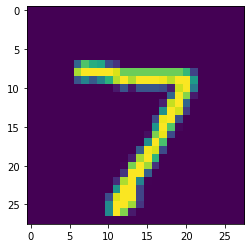

In [26]:
instance = x_test[0]

plt.imshow(np.reshape(instance, (28,28)) )

*The true class of that image is clearly $7$.*

In [27]:
predicted_cat_distr = model.predict(np.expand_dims(instance, 0))
predicted_cat_distr

array([[9.8983837e-05, 7.4795485e-09, 1.1581890e-04, 3.9711050e-03,
        5.2573228e-07, 7.0129638e-05, 3.9099519e-09, 9.9496245e-01,
        1.1723895e-05, 7.6934497e-04]], dtype=float32)

Finally, the predicted class is the one corresponding to the highest probability in the categorical distribution.

In [28]:
predicted_class = np.argmax(predicted_cat_distr)
predicted_class

7

Correct!!! The predicted class is correct.

**Application on more instances at the same time  TODO**

The NN can also be applied to more instances at the same time.

Let's take the first $20$ instances of the valdiation set.

In [23]:
instances = x_test[:20]

In [25]:
# predicted_cat_distr = model.predict(np.expand_dims(instances, 0))
# predicted_cat_distr

### Evaluating the NN

Once we have trained a NN, we can evaluate it to other instances, for getting an evaluation score. This is perfomed using the `evaluate` method.

The `evaluate` method takes in input a dataset `x',y'`: it is typically different from the training set and from the validation set (it is typically the test set). And it computes the value of the loss function and of the optional additional metrics (e.g. accuracy).

For instance, let's apply it this method on the test set. (Even if we have already used this set as validation set). 

*We have always to remember to use `y_test_cat`*.

In [29]:
model.evaluate(x_test, y_test_cat)

313/313 [==============================] - 0s 1ms/step - loss: 0.2561 - accuracy: 0.9271


[0.2561188340187073, 0.9271000027656555]

## HISTORY OF THE TRAINING AND PLOTTING THE RESULTS

### History of the training

The `fit` method returns and object which contains the history of the training process. It contains the loss function and the additional optional metrics computed both on the training and on the validation set. They are computed with respect to each epoch (i.e. at the end of each epch).

In our case, the history of the training contains:
- `loss` (loss computed on the training set)
- `accuracy` (accuracy computed on the training set)
- `val_loss` (loss computed on the validation set)
- `val_accuracy` (accuracy computed on the validation set)

with respect to the each epoch (i.e. they are computed at the end of each epoch).

In [30]:
xin = Input(shape=(784))  # Input layer
x = Dense(units=128, activation='relu')(xin)  # Hidden layer
res = Dense(units=10, activation='softmax')(x)  # Output layer

model = Model(inputs=xin, outputs=res)

In [31]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [32]:
training_history = model.fit(x_train, y_train_cat, batch_size=32, epochs=10, validation_data=(x_test,y_test_cat), 
                              shuffle=True)

Epoch 1/10
1875/1875 [==============================] - 5s 2ms/step - loss: 1.1662 - accuracy: 0.7107 - val_loss: 0.5902 - val_accuracy: 0.8518
Epoch 2/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.4862 - accuracy: 0.8741 - val_loss: 0.4033 - val_accuracy: 0.8938
Epoch 3/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3820 - accuracy: 0.8954 - val_loss: 0.3450 - val_accuracy: 0.9038
Epoch 4/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.3411 - accuracy: 0.9043 - val_loss: 0.3164 - val_accuracy: 0.9105
Epoch 5/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3174 - accuracy: 0.9095 - val_loss: 0.2971 - val_accuracy: 0.9145
Epoch 6/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2999 - accuracy: 0.9139 - val_loss: 0.2843 - val_accuracy: 0.9181
Epoch 7/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2860 - accuracy: 0.9176 - val_loss: 0.2730 - val_accuracy:

The output of the fit method is an object of class `History`. It represents the history of the results obtained during training. These results are contained in the `history` attribute, which is a dictionary. 

In [20]:
training_history.history

{'loss': [0.2586393654346466,
  0.11360926926136017,
  0.0769348219037056,
  0.05652725696563721,
  0.04306340217590332,
  0.03412600979208946,
  0.02629777044057846,
  0.021958477795124054,
  0.017009329050779343,
  0.015356196090579033],
 'accuracy': [0.9260166883468628,
  0.9664833545684814,
  0.9771000146865845,
  0.9825999736785889,
  0.9868000149726868,
  0.9895166754722595,
  0.9917500019073486,
  0.9930833578109741,
  0.994616687297821,
  0.9950666427612305],
 'val_loss': [0.1389441341161728,
  0.09745443612337112,
  0.08447018265724182,
  0.07686164230108261,
  0.0808294340968132,
  0.07276461273431778,
  0.07401105761528015,
  0.0862865000963211,
  0.08917666971683502,
  0.07627350091934204],
 'val_accuracy': [0.9591000080108643,
  0.9713000059127808,
  0.9732999801635742,
  0.9764000177383423,
  0.9764000177383423,
  0.9785000085830688,
  0.9785000085830688,
  0.9746999740600586,
  0.9753000140190125,
  0.9803000092506409]}

Values of `loss`, `accuracy`, `val_loss`, `val_accuracy` with respect to the each epoch.

### Plotting the results of the training

The results contained into the history object can be easily plotted.

We make one plot for the loss function, comparing `loss` and `val_loss` with respect to the number of epochs.

We make also one plot for the accuracy, comparing `accuracy` and `val_accuracy` with respect to the number of epochs.

Text(0.5, 1.0, 'Accuracy')

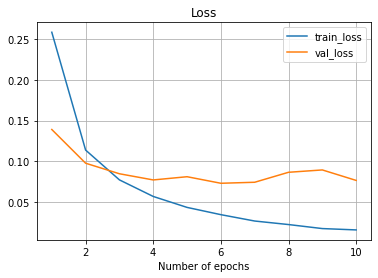

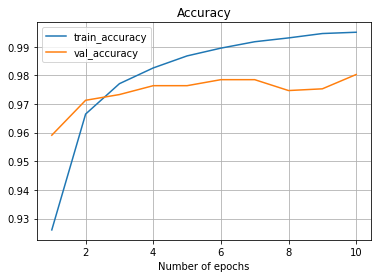

In [24]:
import matplotlib.pyplot as plt

n_epochs = 10
epochs = range(1,n_epochs+1)

plt.plot(epochs, training_history.history['loss'], label='train_loss')
plt.plot(epochs, training_history.history['val_loss'], label='val_loss')
plt.legend()
plt.grid()
plt.xlabel('Number of epochs')
plt.title('Loss')

plt.figure()
plt.plot(epochs, training_history.history['accuracy'], label='train_accuracy')
plt.plot(epochs, training_history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.grid()
plt.xlabel('Number of epochs')
plt.title('Accuracy')

We define a function for doing so.

In [33]:
def plot_history(training_history, n_epochs):
    epochs = range(1,n_epochs+1)

    plt.plot(epochs, training_history.history['loss'], label='train_loss')
    plt.plot(epochs, training_history.history['val_loss'], label='val_loss')
    plt.legend()
    plt.grid()
    plt.xlabel('Number of epochs')
    plt.title('Loss')

    plt.figure()
    plt.plot(epochs, training_history.history['accuracy'], label='train_accuracy')
    plt.plot(epochs, training_history.history['val_accuracy'], label='val_accuracy')
    plt.legend()
    plt.grid()
    plt.xlabel('Number of epochs')
    plt.title('Accuracy')

In [ ]:
plot_history(training_history, n_epochs=10)

### Analyisis of the results

We have made the plots of loss and accuracy with respect of the number of epochs. The number of epochs is very important, because it is a property which impacts to the complexity of the model. Basically, the bigger if the number of epochs, the bigger is the complexity of the model.

This means that the plots of loss/accuracy (both for training and validation) with respect to the number of epochs, are very important for visualizing the situation of the model with respect to overfitting/underfitting. They are very usefult for visualizing if we are in a situation of underfitting/overfitting.

Escpecially overfitting.

In our specific example, we can see that the validation score (either loss or accuracy) is worse in the rigth tail (biggest number of epochs, i.e. biggest complexity) with respect to using a smaller number of epochs. Basically, the goodness of the validation score is worse in the right tail. In addition, the validation score is also very oscillating. 

This means that there is a little bit of **overfitting**!!! The model is too complex.

## HYPERPARAMETERS

In defining the NN, there a lot of hyperparameters that the user can play with. Let's recap some of them.
- Number of hidden dense layers.
- Number of neurons and activation function in each hidden dense layer.
- Loss function
- Optimizer and learning rate
- Batch size and number of epochs

It is important that the user play with these hyperparameters, trying to find the best combination, using a test-and-error approach. *This can important also for reducing overfitting.*

In the following sections we try to play with some of these hyperparameters.

### Number of hidden dense layers

We add three additional hidden dense layers. Four hidden dense layers in total.

In [15]:
xin = Input(shape=(784))  # Input layer
x = Dense(128, activation='relu')(xin)  # First hidden layer. 128 nodes. Relu activation function.
x = Dense(128, activation='relu')(x)  # Second hidden layer. 128 nodes.  Relu activation function.
x = Dense(128, activation='relu')(x)  # Third hidden layer. 128 nodes.  Relu activation function.
x = Dense(128, activation='relu')(x)  # Fourth hidden layer. 128 nodes.  Relu activation function.
res = Dense(10, activation='softmax')(x)  # Output layer

model = Model(inputs=xin, outputs=res)

In [16]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense_3 (Dense)             (None, 128)               100480    
                                                                 
 dense_4 (Dense)             (None, 128)               16512     
                                                                 
 dense_5 (Dense)             (None, 128)               16512     
                                                                 
 dense_6 (Dense)             (None, 128)               16512     
                                                                 
 dense_7 (Dense)             (None, 10)                1290      
                                                                 
Total params: 151,306
Trainable params: 151,306
Non-trainab

In the summary we can see that we have three layers.
1. Input layer. $784$ nodes. No parameters.
2. First Hidden layer. It is a dense layer. $128$ nodes. $785*128=100480$ parameters. (Each node has 784 inputs and 1 bias, and we have $128$ neurons).
3. Second Hidden layer. It is a dense layer. $128$ nodes. $129*128=16512$ parameters. (Each node has 128 inputs and 1 bias, and we have $128$ neurons).
4. Third Hidden layer. It is a dense layer. $128$ nodes. $129*128=16512$ parameters. (Each node has 128 inputs and 1 bias, and we have $128$ neurons).
5. Fourth Hidden layer. It is a dense layer. $128$ nodes. $129*128=16512$ parameters. (Each node has 128 inputs and 1 bias, and we have $128$ neurons).
3. Output layer. It is a dense layer. $10$ nodes. $129*10$ parameters. (Each node has $128$ inputs and $1$ bias, and we have $10$ neurons).

On the whole, $151306$ parameters.

Same compiling and fitting as before.

In [17]:
model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

In [18]:
model.fit(x_train, y_train_cat, batch_size=32, epochs=10, validation_data=(x_test,y_test_cat), shuffle=True)

Epoch 1/10
1875/1875 [==============================] - 10s 4ms/step - loss: 0.2406 - accuracy: 0.9261 - val_loss: 0.1253 - val_accuracy: 0.9639
Epoch 2/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1070 - accuracy: 0.9670 - val_loss: 0.0994 - val_accuracy: 0.9704
Epoch 3/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0792 - accuracy: 0.9759 - val_loss: 0.1107 - val_accuracy: 0.9681
Epoch 4/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0646 - accuracy: 0.9801 - val_loss: 0.0865 - val_accuracy: 0.9741
Epoch 5/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0548 - accuracy: 0.9828 - val_loss: 0.0953 - val_accuracy: 0.9718
Epoch 6/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0441 - accuracy: 0.9861 - val_loss: 0.0952 - val_accuracy: 0.9749
Epoch 7/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0386 - accuracy: 0.9882 - val_loss: 0.0800 - val_accuracy

Loss in the training set: $0.0289$. Worse than before.

Loss in the test set: $0.0829$. Worse than before.

### Activation functions of the hidden layers

We consider the NN with only one hidden dense layer. We replace the `relu` activation function with another activation function.

**softmax**

In [ ]:
xin = Input(shape=(784))  # Input layer
x = Dense(128, activation='softmax')(xin)  # Hidden layer. SOFTMAX activation function.
res = Dense(10, activation='softmax')(x)  # Output layer

model = Model(inputs=xin, outputs=res)

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
model.fit(x_train, y_train_cat, batch_size=32, epochs=10, validation_data=(x_test,y_test_cat), shuffle=True)

Epoch 1/10
1875/1875 [==============================] - 8s 4ms/step - loss: 1.2203 - accuracy: 0.8098 - val_loss: 0.6601 - val_accuracy: 0.8496
Epoch 2/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.5186 - accuracy: 0.8627 - val_loss: 0.4351 - val_accuracy: 0.8637
Epoch 3/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3938 - accuracy: 0.8819 - val_loss: 0.3777 - val_accuracy: 0.8925
Epoch 4/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3392 - accuracy: 0.9096 - val_loss: 0.3325 - val_accuracy: 0.9092
Epoch 5/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2980 - accuracy: 0.9237 - val_loss: 0.3090 - val_accuracy: 0.9194
Epoch 6/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2732 - accuracy: 0.9296 - val_loss: 0.2901 - val_accuracy: 0.9254
Epoch 7/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2559 - accuracy: 0.9340 - val_loss: 0.2849 - val_accuracy:

Much worse than using 'relu'.

**selu**

In [ ]:
xin = Input(shape=(784))  # Input layer
x = Dense(128, activation='selu')(xin)  # Hidden layer. SELU activation function.
res = Dense(10, activation='softmax')(x)  # Output layer

model = Model(inputs=xin, outputs=res)

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:
model.fit(x_train, y_train_cat, batch_size=32, epochs=10, validation_data=(x_test,y_test_cat), shuffle=True)

Epoch 1/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.3108 - accuracy: 0.9097 - val_loss: 0.1938 - val_accuracy: 0.9421
Epoch 2/10
1875/1875 [==============================] - 7s 3ms/step - loss: 0.1652 - accuracy: 0.9518 - val_loss: 0.1447 - val_accuracy: 0.9556
Epoch 3/10
1875/1875 [==============================] - 7s 3ms/step - loss: 0.1121 - accuracy: 0.9663 - val_loss: 0.1074 - val_accuracy: 0.9671
Epoch 4/10
1875/1875 [==============================] - 7s 3ms/step - loss: 0.0832 - accuracy: 0.9749 - val_loss: 0.1004 - val_accuracy: 0.9710
Epoch 5/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0659 - accuracy: 0.9796 - val_loss: 0.0915 - val_accuracy: 0.9729
Epoch 6/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0520 - accuracy: 0.9835 - val_loss: 0.0818 - val_accuracy: 0.9742
Epoch 7/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0430 - accuracy: 0.9857 - val_loss: 0.0840 - val_accuracy:

A little bit worse than using 'relu'.

**elu**

In [ ]:
xin = Input(shape=(784))  # Input layer
x = Dense(128, activation='elu')(xin)  # Hidden layer. ELU activation function.
res = Dense(10, activation='softmax')(x)  # Output layer

model = Model(inputs=xin, outputs=res)

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [20]:
model.fit(x_train, y_train_cat, batch_size=32, epochs=10, validation_data=(x_test,y_test_cat), shuffle=True)

Epoch 1/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.3003 - accuracy: 0.9132 - val_loss: 0.1703 - val_accuracy: 0.9526
Epoch 2/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1422 - accuracy: 0.9582 - val_loss: 0.1159 - val_accuracy: 0.9649
Epoch 3/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0952 - accuracy: 0.9717 - val_loss: 0.1039 - val_accuracy: 0.9702
Epoch 4/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0686 - accuracy: 0.9789 - val_loss: 0.0785 - val_accuracy: 0.9747
Epoch 5/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0533 - accuracy: 0.9834 - val_loss: 0.0818 - val_accuracy: 0.9740
Epoch 6/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0408 - accuracy: 0.9866 - val_loss: 0.0792 - val_accuracy: 0.9749
Epoch 7/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0333 - accuracy: 0.9893 - val_loss: 0.0781 - val_accuracy:

The loss on the training set is worse than using 'relu', while the loss on the test set is better.

The accuracies are better using 'relu'.

## SPARSE CATEGORICAL CROSSENTROPY

### General description

Sparse categorical crossentropy is another loss function, which is an alternative to the classic categorical crossentropy.

They are applied in the same situation, which is the situation in which the output of the NN is a probability distribution over the different classes (i.e. categorical distribution over the different classes).

They also give very similar results in terms of goodness of the results and of the training.

The (main) only difference is that sparse categorical crossentropy saves the user from pre-processing the target vector `y`. Indeed, we know that with the classic categorical crossentropy, the user has to pre-process the target vector `y`, in such a way that it does not contain anymore simple labels, but it contains the true categorical distributions of the inctances. In sparse categorical crossentropy this is not needed anymore.

**More in depth explanation**

Let $k$ be the number of different classes.

Since now, we have seen the categorial_crossentropy. The output of the NN, given an instance, is a vector of probabilities $[p_1, ..., p_k]$ (i.e. categorical distribution), where $p_i$ is the probability that the instance has the class $i$. According to that, also the target vector must $y$ must be transformed. Each element is not a single integer representing the class, but it is a vector representing the categorical distribution: vector $[0, ..., 1, ..., 0]$, where the single element which is equal to $1$ is the element with index the class of that instance.

With the sparse_categorical_crossentropy the output of the NN is still a vector with $k$ elements. So the output layer has still $k$ neurons. The difference is that we leave the target vector $y$ as it is: we don't need to transform it. Basically, each element of $y$ is a single integer, which is the class of the corresponding instance. In the target vector $y$ we don't use the categorical distribution, but the actual labels. 

### Using sparse categorical crossentropy

We use the NN with a single NN and `relu` activation function.

In [ ]:
xin = Input(shape=(784))  # Input layer
x = Dense(128, activation='relu')(xin)  # Hidden layer
res = Dense(10, activation='softmax')(x)  # Output layer

model = Model(inputs=xin, outputs=res)

We specify `sparse_categorical_crossentropy` as loss function.

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

**We use `y_train` and `y_test` as they are. No categorical distributions, no `y_train_cat` and `y_test_cat`. But actual integer labels.**

In [26]:
model.fit(x_train, y_train, batch_size=32, epochs=10, validation_data=(x_test,y_test), shuffle=True)

Epoch 1/10
1875/1875 [==============================] - 7s 3ms/step - loss: 0.2589 - accuracy: 0.9271 - val_loss: 0.1265 - val_accuracy: 0.9634
Epoch 2/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1127 - accuracy: 0.9663 - val_loss: 0.1019 - val_accuracy: 0.9686
Epoch 3/10
1875/1875 [==============================] - 7s 3ms/step - loss: 0.0775 - accuracy: 0.9768 - val_loss: 0.0896 - val_accuracy: 0.9714
Epoch 4/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0588 - accuracy: 0.9822 - val_loss: 0.0974 - val_accuracy: 0.9694
Epoch 5/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0447 - accuracy: 0.9860 - val_loss: 0.0834 - val_accuracy: 0.9732
Epoch 6/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0366 - accuracy: 0.9886 - val_loss: 0.0777 - val_accuracy: 0.9755
Epoch 7/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0290 - accuracy: 0.9911 - val_loss: 0.0789 - val_accuracy:

(Slightly) better results than using categorical_crossentropy.

But the major advantage is that we didn't pre-process the target vector `y`!

### Important insight

This is an important insight, which involves the specific keras implementation.

The `SparseCategoricalCrossentropy` has an optional parameter, called `from_logits`. By default, it is `False`.

In theory, the two following approaches are equivalent.
1. Using an output layer with the softmax activation function and compiling the NN using the `SparseCategoricalCrossentropy` with `from_logits=False`.
2. Using an output layer without the softmax activation function (no activation function) and compiling the NN using the `SparseCategoricalCrossentropy` with `from_logits=True`.

The first approach seems the better one, because it makes more sense.

However, it is recommended to use the second approach. Because, in keras, the second approach brings more numerical stability in the computation of the gradients. [Here](https://stackoverflow.com/questions/61233425/what-should-i-use-as-target-vector-when-i-use-binarycrossentropyfrom-logits-tru/61237426#61237426) you can find some reasons why.

So, it woulde have been better to proceed in the following way.

In [ ]:
# Model
xin = Input(shape=(784))  
x = Dense(128, activation='relu')(xin)  
res = Dense(10)(x)  # NO ACTIVATION FUNCTION  

model = Model(inputs=xin, outputs=res)

In [ ]:
model.compile(optimizer=Adam(learning_rate=1e-3), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy'])